**Elemento de viga**

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# dados de entrada

tipo = 'engastada-engastada' # bi-apoiada, engastada-livre, obs: quaisquer outras condições de contorno podem ser adicionadas no terceiro bloco de códigos, na parte de restrições verticais e horizontais

numero_de_elementos = 50

L = 20000      # tamanho da viga em mm
E = 200e3      # Módulo de Young em MPa
I = 150.52e6   # momento de inércia da seção trasnversal em mm^4
EI = E*I     # rigidez da viga em N*mm²
C = -5000     # carga concentrada em N
M = 0          # momento concentrado em N*mm

# cargas distribuídas (w), cargas concentradas (F1 e F2) e momentos concentrados (M1 e M2). obs: F1 corresponde à carga aplicada no primeiro nó de cada elemento, já F2 no segundo nó (o mesmo vale para os momentos)

w = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])      # N/mm

F1 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, C, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])     # N
M1 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])     # N*mm
F2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, C, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])     # N
M2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])     # N*mm


In [11]:
coordenadas_dos_nos = np.linspace(0, L, numero_de_elementos + 1)
numero_de_nos = coordenadas_dos_nos.shape[0]

nos_dos_elementos = np.zeros((numero_de_elementos, 2), dtype=int)
for i in range(numero_de_elementos):
    nos_dos_elementos[i, 0] = i
    nos_dos_elementos[i, 1] = i + 1

graus_de_liberdade_por_no = 2 * numero_de_nos
U = np.zeros(graus_de_liberdade_por_no)

def montar_matriz_de_rigidez(graus_de_liberdade_por_no, numero_de_elementos, nos_dos_elementos, numero_de_nos, EI, w, F1, M1, F2, M2):
    forca = np.zeros(graus_de_liberdade_por_no)
    matriz_de_rigidez = np.zeros((graus_de_liberdade_por_no, graus_de_liberdade_por_no))

    for e in range(numero_de_elementos):
        indice = nos_dos_elementos[e, :]
        grau_de_liberdade_do_elemento = [2 * (indice[0]) , 2 * (indice[1])-1, 2 * (indice[1]) , 2 * (indice[1]) + 1]

        comprimento_do_elemento = numero_de_nos[indice[1]] - numero_de_nos[indice[0]]
        k1 = EI / (comprimento_do_elemento)**3 * np.array([[12, 6 * comprimento_do_elemento, -12, 6 * comprimento_do_elemento],
                                         [6 * comprimento_do_elemento, 4 * comprimento_do_elemento**2, -6 * comprimento_do_elemento, 2 * comprimento_do_elemento**2],
                                         [-12, -6 * comprimento_do_elemento, 12, -6 * comprimento_do_elemento],
                                         [6 * comprimento_do_elemento, 2 * comprimento_do_elemento**2, -6 * comprimento_do_elemento, 4 * comprimento_do_elemento**2]])

        f1 = np.array([w[e] * comprimento_do_elemento / 2, w[e] * comprimento_do_elemento * comprimento_do_elemento / 12, w[e] * comprimento_do_elemento / 2, -w[e] * comprimento_do_elemento * comprimento_do_elemento / 12]) + np.array([F1[e], M1[e], F2[e], M2[e]])

        forca[grau_de_liberdade_do_elemento] += f1
        matriz_de_rigidez[np.ix_(grau_de_liberdade_do_elemento, grau_de_liberdade_do_elemento)] += k1

    return matriz_de_rigidez, forca

def solucao(graus_de_liberdade_por_no, no_prescrito, matriz_de_rigidez, force):
    grau_de_liberdade_ativo = np.setdiff1d(np.arange(graus_de_liberdade_por_no), no_prescrito)
    U = np.linalg.solve(matriz_de_rigidez[np.ix_(grau_de_liberdade_ativo, grau_de_liberdade_ativo)], force[grau_de_liberdade_ativo])
    deslocamentos = np.zeros(graus_de_liberdade_por_no)
    deslocamentos[grau_de_liberdade_ativo] = U
    return deslocamentos

matriz_de_rigidez, forca = montar_matriz_de_rigidez(graus_de_liberdade_por_no, numero_de_elementos, nos_dos_elementos, coordenadas_dos_nos, EI, w, F1, M1, F2, M2)



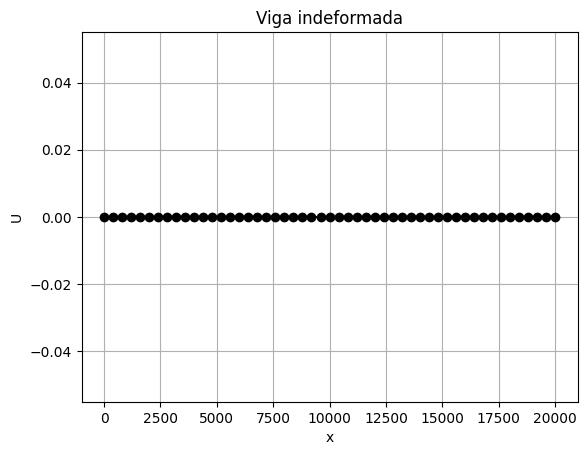

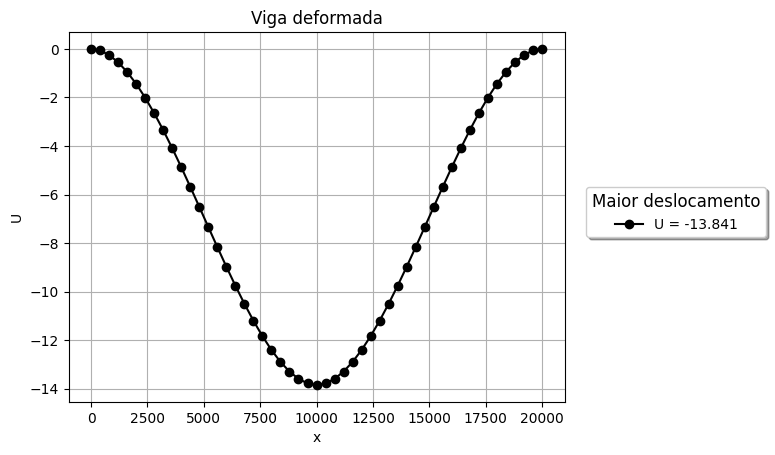

In [12]:
if 'engastada-engastada' in tipo:
    restricao_vertical = np.array([0, 2*numero_de_elementos])  
    restricao_horizontal = np.array([1, 2*numero_de_elementos+1])  

if 'engastada-livre' in tipo:
    restricao_vertical = np.array([0])  
    restricao_horizontal = np.array([1])  

if 'bi-apoiada' in tipo:
    restricao_vertical = np.array([0, 2*numero_de_elementos])  
    restricao_horizontal = np.array([])  

no_prescrito = np.concatenate((restricao_vertical, restricao_horizontal))

deslocamentos = solucao(graus_de_liberdade_por_no, no_prescrito, matriz_de_rigidez, forca)

U = deslocamentos[::2] 

U_max = max(U, key=abs)

plt.plot(coordenadas_dos_nos, np.zeros(len(coordenadas_dos_nos)), '-', marker = 'o', color='k')
plt.xlabel('x')
plt.ylabel('U')
plt.title('Viga indeformada')
plt.grid(True)
plt.show()

plt.plot(coordenadas_dos_nos, U, '-', marker = 'o', color='k')
plt.xlabel('x')
plt.ylabel('U')
plt.legend(['U = {}'.format(np.round(U_max,3))],title='Maior deslocamento', title_fontsize='large', loc='upper left', shadow=True, fancybox=True, bbox_to_anchor=(1.03, 0.6))
plt.title('Viga deformada')
plt.grid(True)
plt.show()

In [13]:
#%reset -f